In [22]:
from model import FaceRec
from sklearn.datasets import fetch_lfw_people
from PIL import Image, ImageFilter
import matplotlib.pyplot as plt
import numpy as np

In [4]:
CKPT_LOCATION = 'checkpoints/c1s_9_c2n_64_rs_1_c2s_6_c2d_0.7_lr_0.0001_c2vl_32_c1n_256_c1vl_16_c1s_5_c1nf_16--FaceRec--1522700434.769402'

In [5]:
model = FaceRec("FaceRec", output_folder='/tmp')
model.load(CKPT_LOCATION)

ModelBase::Loading ckpt ...


'model_variables' collection should be of type 'byte_list', but instead is of type 'node_list'.


The saved meta_graph is possibly from an older release:
'model_variables' collection should be of type 'byte_list', but instead is of type 'node_list'.


INFO:tensorflow:Restoring parameters from checkpoints/c1s_9_c2n_64_rs_1_c2s_6_c2d_0.7_lr_0.0001_c2vl_32_c1n_256_c1vl_16_c1s_5_c1nf_16--FaceRec--1522700434.769402


Restoring parameters from checkpoints/c1s_9_c2n_64_rs_1_c2s_6_c2d_0.7_lr_0.0001_c2vl_32_c1n_256_c1vl_16_c1s_5_c1nf_16--FaceRec--1522700434.769402
ModelBase::Ckpt ready


Type is unsupported, or the types of the items don't match field type in CollectionDef.
'Tensor' object has no attribute 'to_proto'


Error encountered when serializing model_variables.
Type is unsupported, or the types of the items don't match field type in CollectionDef.
'Tensor' object has no attribute 'to_proto'


In [6]:
people = fetch_lfw_people(color=True, min_faces_per_person=25)

In [26]:
def downsample_images(img):
    img = Image.fromarray(img.astype('uint8'), 'RGB')
    img = img.resize((32,32), Image.ANTIALIAS)
    return np.array(img)

def rotate_images(img, degree=180):
    img = img * 255
    img = Image.fromarray(img.astype('uint8'), 'RGB')
    img = img.rotate(degree)
    return np.array(img)/255

def blur_image(img, sigma=0.1):
    img = img * 255
    img = Image.fromarray(img.astype('uint8'), 'RGB')
    img = img.filter(ImageFilter.GaussianBlur(sigma))
    return np.array(img)/255

X_faces = people.images
Y_faces = people.target
target_names = people.target_names

X_faces = np.array([downsample_images(ab) for ab in X_faces])
X_faces = X_faces / 255
X_faces_rotated = np.array([rotate_images(ab) for ab in X_faces])

In [8]:
def get_top_5_prediction(image):
    softmax = model.predict(np.array([image]))
    top_5 = softmax.argsort()[0][-5:][::-1]
    top_5_names = [(target_names[i], softmax[0][i]) for i in top_5]
    return top_5_names

def print_top_5_prediction(image):
    top_5_names = get_top_5_prediction(image)
    print("\nPredicted Names and softmax score: ")
    for name in top_5_names:
        print("%s: %s" %(name[0], name[1]))

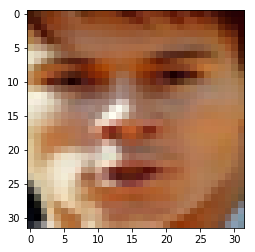

In [51]:
index = 144
image = X_faces[index]
plt.imshow(image)

In [58]:
get_top_5_prediction(image)

[('Jennifer Capriati', 0.029991947),
 ('Laura Bush', 0.027784284),
 ('Guillermo Coria', 0.027079802),
 ('Gerhard Schroeder', 0.0268241),
 ('Arnold Schwarzenegger', 0.02634984)]

In [57]:
target_names[Y_faces[index]]

'Guillermo Coria'

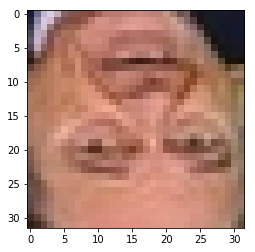

In [12]:
image_rotated = rotate_images(image)
plt.imshow(image_rotated)

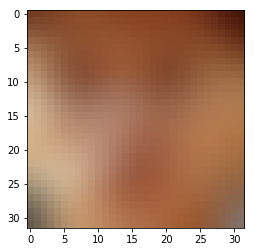

In [56]:
image_blurred = blur_image(image,3)
plt.imshow(image_blurred)

In [34]:
from data_handler import get_face_data

x_train, y_train, x_test, y_test = get_face_data()
x_test = x_test / 255
x_train = x_train / 255

In [58]:
def get_loss_acc_for_rotated_images(degree):
    x_rotated_test = np.array([rotate_images(ab, degree) for ab in x_test])
    loss, acc, _ = model.evaluate_dataset(x_rotated_test, y_test)
    print("Rotated Test dataset (%s degrees), loss = %s, acc = %s" % (degree, loss, acc))
    return loss, acc


In [39]:
def get_loss_acc_for_blurred_images(sigma):
    x_blurred_test = np.array([blur_image(ab, sigma) for ab in x_test])
    loss, acc, _ = model.evaluate_dataset(x_blurred_test, y_test)
    print("Blurred Test dataset (%s sigma), loss = %s, acc = %s" % (sigma, loss, acc))
    return loss, acc

In [59]:
loss, acc = get_loss_acc_for_rotated_images(180)

Rotated Test dataset (180 degrees), loss = 0.8253456, acc = 0.052941176470588235


In [61]:
loss, acc = get_loss_acc_for_rotated_images(10)

Rotated Test dataset (10 degrees), loss = 0.2792917, acc = 0.7803921568627451


In [45]:
loss, acc = get_loss_acc_for_blurred_images(5)

Blurred Test dataset (5 sigma), loss = 0.6148513, acc = 0.1588235294117647


Rotated Test dataset (5 degrees), loss = 0.1536024, acc = 0.9313725490196079
Rotated Test dataset (10 degrees), loss = 0.2792917, acc = 0.7803921568627451
Rotated Test dataset (30 degrees), loss = 0.73775244, acc = 0.17647058823529413
Rotated Test dataset (45 degrees), loss = 0.8269824, acc = 0.054901960784313725
Rotated Test dataset (90 degrees), loss = 0.7646246, acc = 0.049019607843137254
Rotated Test dataset (115 degrees), loss = 0.79466015, acc = 0.041176470588235294
Rotated Test dataset (180 degrees), loss = 0.8253456, acc = 0.052941176470588235


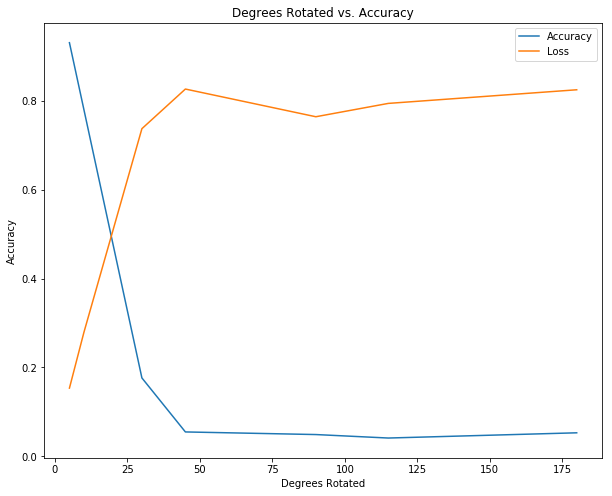

In [63]:
degrees = [5, 10, 30, 45, 90, 115, 180]
total_acc = []
total_loss = []

for degree in degrees:
    loss, acc = get_loss_acc_for_rotated_images(degree)
    total_loss.append(loss)
    total_acc.append(acc)
    
plt.figure(figsize=(10,8))
plt.title('Degrees Rotated vs. Accuracy')
plt.xlabel('Degrees Rotated')
plt.ylabel('Accuracy')
plt.plot(degrees, total_acc, label='Accuracy')
plt.plot(degrees, total_loss, label='Loss')
plt.legend(loc='best')
plt.show()

Blurred Test dataset (0.1 sigma), loss = 0.08788459, acc = 0.9372549019607843
Blurred Test dataset (0.5 sigma), loss = 0.0929313, acc = 0.9372549019607843
Blurred Test dataset (1 sigma), loss = 0.1345572, acc = 0.9313725490196079
Blurred Test dataset (1.5 sigma), loss = 0.22201838, acc = 0.8627450980392157
Blurred Test dataset (2 sigma), loss = 0.31600922, acc = 0.703921568627451
Blurred Test dataset (2.5 sigma), loss = 0.40148932, acc = 0.5254901960784314
Blurred Test dataset (3 sigma), loss = 0.46428537, acc = 0.39019607843137255
Blurred Test dataset (4 sigma), loss = 0.55547607, acc = 0.24705882352941178
Blurred Test dataset (5 sigma), loss = 0.6148513, acc = 0.1588235294117647
Blurred Test dataset (6 sigma), loss = 0.6564907, acc = 0.11176470588235295


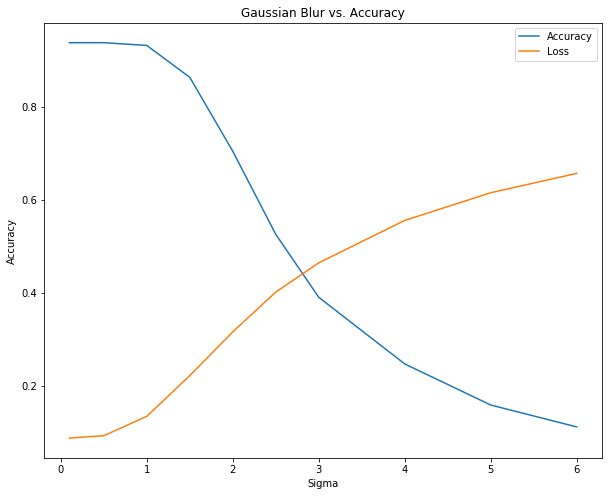

In [46]:
sigmas = [0.1, 0.5, 1, 1.5, 2, 2.5, 3, 4, 5, 6]
total_acc = []
total_loss = []

for sigma in sigmas:
    loss, acc = get_loss_acc_for_blurred_images(sigma)
    total_loss.append(loss)
    total_acc.append(acc)
    
plt.figure(figsize=(10,8))
plt.title('Gaussian Blur vs. Accuracy')
plt.xlabel('Sigma')
plt.ylabel('Accuracy')
plt.plot(sigmas, total_acc, label='Accuracy')
plt.plot(sigmas, total_loss, label='Loss')
plt.legend(loc='best')
plt.show()

Sigma = 0.100000
Sigma = 0.500000
Sigma = 1.000000
Sigma = 1.500000
Sigma = 2.000000
Sigma = 2.500000
Sigma = 3.000000
Sigma = 4.000000
Sigma = 5.000000
Sigma = 6.000000


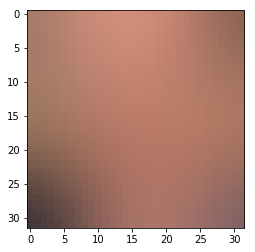

In [49]:
for sigma in sigmas:
    image_blurred = blur_image(image,sigma)
    print("Sigma = %f" % sigma)
    plt.imshow(image_blurred)

In [66]:
img = Image.open('george_bush.png')

STREAM b'IHDR' 16 13
STREAM b'IDAT' 41 8192


In [73]:
image = img.convert('RGB').resize((32, 32), Image.ANTIALIAS)
image = np.array(image) / 255